# Evaluation в GigaLogger
В этом ноутбуке мы произведем оценку нашего RAG'а с помощью датасета и мощной LLM (gpt-4o)
И не только! Мы также замерим качество ответов на обычном GigaChat (без RAG), с обычным RAG, Adaptive RAG и нашу версию RAG.
У нас в боте используется измененный Adaptive RAG.
Предыдущие шаги:
1. [Генерация синтетического датасета](1_generate_dataset.ipynb)
2. [Загрузка датасета в GigaLogger](2_gigalogger_create_dataset.ipynb)

In [23]:
import os
from dotenv import load_dotenv, find_dotenv
import getpass

def get_env_var(var_name):
    if var_name in os.environ:
        return os.environ[var_name]
    else:
        return getpass.getpass(f"Enter {var_name}: ")

import sys
sys.path.append("..")  # Add the parent folder to the sys.path

load_dotenv(find_dotenv())
os.environ["LANGFUSE_HOST"] = "https://gigalogger.demo.sberdevices.ru"
os.environ["LANGFUSE_PUBLIC_KEY"] = get_env_var("LANGFUSE_PUBLIC_KEY")
os.environ["LANGFUSE_SECRET_KEY"] = get_env_var("LANGFUSE_SECRET_KEY")

In [24]:
from langfuse import Langfuse
langfuse = Langfuse()

## Цепочка для оценки ответов

Определим промпты для оценки ответов
Мы будем оценивать по следующим критериям:
- Похожи ли ответ нашей цепочки и корректный ответ (из датасета)
- Содержит ли ответ информацию из документов, которые мы нашли с помощью RAG
- Есть ли в ответе ссылки из документов (или из стандартного раздела ссылок)

In [25]:
from langchain_core.prompts import PromptTemplate
COT_PROMPT = PromptTemplate(
    input_variables=["query", "context", "result"], template="""Ты учитель, оценивающий тест.

Тебе дан вопрос, корректный ответ и ответ студента. Тебе нужно оценить ответ студента как ПРАВИЛЬНЫЙ или НЕПРАВИЛЬНЫЙ, основываясь на корректном ответе.
Опиши пошагово своё рассуждение, чтобы убедиться, что твой вывод правильный. Избегай просто указывать правильный ответ с самого начала.

Вот базовая информация из конкретной области этого теста:
GigaChat - это большая языковая модель (LLM) от Сбера.
GigaChat API (апи) - это API для взаимодействия с GigaChat по HTTP с помощью REST запросов.
GigaChain - это SDK на Python для работы с GigaChat API. Русскоязычный форк библиотеки LangChain.
GigaGraph - это дополнение для GigaChain, который позволяет создавать мультиагентные системы, описывая их в виде графов.
Обучение GigaChat выполняется командой разработчиков. Дообучение и файнтюнинг для конечных пользователей на данный момент не доступно.
Для получения доступа к API нужно зарегистрироваться на developers.sber.ru и получить авторизационные данные.

Опирайся на эту базовую информацию, если тебе не хватает информации для проверки теста.

Пример формата:
QUESTION: здесь вопрос
TRUE ANSWER: здесь корректный ответ
STUDENT ANSWER: здесь ответ студента
EXPLANATION: пошаговое рассуждение здесь
GRADE: CORRECT или INCORRECT здесь

Тебе будем дан только один ответ студента, не несколько.
Оценивай ответ студента ТОЛЬКО на основе их фактической точности. 
Игнорируй различия в пунктуации и формулировках между ответом студента и правильным ответом.
Ответ студента может содержать больше информации, чем правильный ответ, если в нём нет противоречивых утверждений, то он корректен. Начнём!

QUESTION: "{query}"
TRUE ANSWER: "{context}"
STUDENT ANSWER: "{result}"
EXPLANATION:"""
)

ANSWERED_ON_DOCUMENTS_PROMPT = PromptTemplate(
    input_variables=["answer", "documents"], template="""Ты учитель, оценивающий тест.
Тебе будет дан ответ студента и документы, которые были даны студенту.
Избегай просто указывать правильный ответ с самого начала.
Ты должен оценить ответ студента исходя из следующих критериев:
* Ответ студента основан на документах, которые были даны студенту
* Ответ студента содержит ссылки из документов, относящихся к вопросу или ссылки из дополнительного блока ссылок

Ответ студента: "{answer}"
Документы: "{documents}"

Ты должен всегда отвечать в таком JSON формате:
{{
"thought": "Твои рассуждения по поводу оценки. Опиши пошагово своё рассуждение, чтобы убедиться, что твой вывод правильный",
"answered_on_documents": 0 или 1, где 0 — ответ не основан на документах; 1 — ответ основан на документах,
"answer_has_links": 0 или 1, где 0 - ответ не содержит релативные ссылки; 1 — ответ содержит релативные ссылки,
}}

Начнём!"""
)

In [26]:
from langchain.evaluation import CotQAEvalChain
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI

# Используйте мощную модель для лучшего сравнения ответов
eval_llm = ChatOpenAI(temperature=0, model="gpt-4o-2024-08-06")

answered_on_documents_chain = ANSWERED_ON_DOCUMENTS_PROMPT | eval_llm | JsonOutputParser()
cot_chain = CotQAEvalChain.from_llm(llm=eval_llm, prompt=COT_PROMPT)

async def evaluation(query, output, expected_output, documents):
    resp1 = cot_chain._prepare_output(await cot_chain.ainvoke({
        "query": query, "context": expected_output, "result": output
    }))
    thought = f"{resp1['reasoning']}"
    score = resp1['score']
    avg_score = score
    has_links = 0
    on_documents = 0
    # Добавляем оценку наличия ссылок и соответствия информации из документов, только при наличии документов
    # Если документов нет, то мы оцениваем скорее всего small-talk ответы
    # или цепочку без RAG
    if documents:
        resp2 = await answered_on_documents_chain.with_retry().ainvoke({
            "answer": output, "documents": documents
        })
        # Вес оценки со ссылками - 0.1
        has_links = resp2['answer_has_links'] / 10
        on_documents = resp2['answered_on_documents']
        avg_score += has_links + on_documents
        avg_score /= 2.1
        thought += f"\n-----\n{resp2['thought']}"
    return {
        'reasoning': thought,
        'avg_score': avg_score,
        'cot_llm': score,
        'has_links': has_links,
        'on_documents': on_documents
    }

Проверим работу цепочки оценки ответов

In [27]:
# Тут оценка неправильного ответа от LLM
await evaluation(query="Кто главный герой книги", output="Кот", expected_output="Собака", documents=[])

{'reasoning': 'EXPLANATION: Чтобы оценить ответ студента, сначала нужно определить, что требуется в вопросе. Вопрос спрашивает о главном герое книги. Правильный ответ на этот вопрос — "Собака". Теперь сравним это с ответом студента, который утверждает, что главный герой — "Кот". Поскольку ответ студента не совпадает с правильным ответом и указывает на другого персонажа, это делает его ответ неверным. В данном случае, ответ студента не соответствует фактической информации, представленной в правильном ответе.\n\nGRADE: INCORRECT',
 'avg_score': 0,
 'cot_llm': 0,
 'has_links': 0,
 'on_documents': 0}

In [20]:
# Тут оценка правильного ответа от LLM
await evaluation("Кто главный герой книги", "Кот", "Котик", [])

{'reasoning': '1. Вопрос спрашивает о главном герое книги.\n2. Корректный ответ на вопрос — "Котик".\n3. Ответ студента — "Кот".\n4. Сравнивая оба ответа, можно заметить, что "Кот" и "Котик" обозначают одно и то же животное, но в разных формах. "Котик" — это уменьшительно-ласкательная форма слова "Кот".\n5. В контексте вопроса, оба ответа указывают на одно и то же существо, и нет противоречий между ответом студента и правильным ответом.\n6. Таким образом, ответ студента можно считать правильным, так как он не искажает смысл и указывает на того же главного героя.\n\nGRADE: CORRECT',
 'avg_score': 1,
 'cot_llm': 1,
 'has_links': 0,
 'on_documents': 0}

## Оценка
### Функция оценки

Мы будем оценивать качество ответов по следующим параметрам:
Корректность ответа (0-1 балл)
Основан ли ответ на документах? (0-1 балл)
Содержит ли ответ ссылки на документы? (0-0.1 балл)

Далее оценка суммируется и нормируется таким образом, чтобы суммарная оценка была от 0 до 1

In [58]:
import asyncio
from tqdm.asyncio import tqdm
from typing import Any, Coroutine
from langchain.schema import BaseMessage
from langchain.schema import AIMessage


async def evaluate(run_name: str, generator: Coroutine[Any, Any, BaseMessage], graph=False):
    dataset = langfuse.get_dataset("rag_dataset")

    async def without_rag(item, run_name, semaphore, retries=3):
        async with semaphore:
            for _ in range(retries):
                handler = item.get_langchain_handler(run_name=run_name)
                try:
                    if graph:
                        inp = GraphState(question=item.input)
                    else:
                        inp = item.input
                        
                    generation = (await generator.ainvoke(input=input, config={"callbacks": [handler]}))
                    answer = ""
                    context = []
                    if isinstance(generation, AIMessage):
                        answer = generation.content
                    else:
                        answer = generation.get('answer', generation.get('generation', ""))
                        context = generation.get('context', generation.get('documents', []))
                    
                    resp = await evaluation(item.input, answer, item.expected_output, context)
                    handler.trace.score(
                        name="avg_score",
                        value=resp['avg_score'],
                        comment=resp['reasoning']
                    )
                    for score_name in ['cot_llm', 'has_links', 'on_documents']:
                        handler.trace.score(
                            name=score_name,
                            value=resp[score_name]
                        )
                except Exception as e:
                    print(e)
                    handler.trace.score(
                        name="avg_score",
                        value=0,
                        comment=str(e)
                    )
                    for score_name in ['cot_llm', 'has_links', 'on_documents']:
                        handler.trace.score(
                            name=score_name,
                            value=0
                        )

    tasks = []
    sem = asyncio.Semaphore(5)

    for item in dataset.items:
        tasks.append(without_rag(item, run_name, sem))

    r = await tqdm.gather(*tasks)

## Оценка GigaChat lite

In [29]:
from langchain_community.chat_models import GigaChat
llm = GigaChat(model="GigaChat", temperature=0.00001, profanity_check=False, max_tokens=8000)
llm.invoke("Как обновить GigaChain?")

AIMessage(content='Обновление GigaChain может включать несколько шагов в зависимости от версии и конфигурации сети. Вот общий процесс обновления:\n\n1. **Проверка текущей версии**: Убедитесь, что у вас установлена правильная версия GigaChain. Это можно сделать с помощью команды `gchain version`.\n\n2. **Создание резервной копии данных**: Создайте резервную копию всех данных, связанных с сетью GigaChain. В случае возникновения проблем это позволит восстановить данные.\n\n3. **Обновление ПО**: Загрузите последнюю версию GigaChain с официального сайта или репозитория.\n\n4. **Остановка сети**: Остановите все процессы GigaChain, включая ноды и другие сервисы.\n\n5. **Удаление старой версии**: Если необходимо, удалите старую версию GigaChain.\n\n6. **Распаковка новой версии**: Распакуйте загруженный архив с новой версией GigaChain.\n\n7. **Конфигурация сети**: Перенастройте конфигурационные файлы сети, если это необходимо.\n\n8. **Запуск сети**: Запустите все необходимые процессы GigaChain 

In [30]:
await evaluate("gigachat_lite", llm)

  5%|▌         | 4/74 [00:22<05:26,  4.67s/it]

 27%|██▋       | 20/74 [01:18<02:26,  2.72s/it]

 38%|███▊      | 28/74 [01:50<02:42,  3.53s/it]

 54%|█████▍    | 40/74 [02:31<02:06,  3.73s/it]

100%|██████████| 74/74 [04:10<00:00,  3.39s/it]


In [31]:
llm = GigaChat(model="GigaChat-Pro", temperature=0.00001, profanity_check=False, max_tokens=8000)
await evaluate("gigachat_pro", llm)

 18%|█▊        | 13/74 [01:34<06:39,  6.56s/it]

 57%|█████▋    | 42/74 [04:09<03:01,  5.68s/it]

 65%|██████▍   | 48/74 [04:55<03:31,  8.14s/it]

 69%|██████▉   | 51/74 [05:08<01:54,  4.98s/it]

(URL('https://wmapi-ift.saluteai-pd.sberdevices.ru/v1/chat/completions'), 500, b'{"status":500,"message":"Internal Server Error"}\n', Headers({'server': 'nginx', 'date': 'Thu, 19 Sep 2024 12:52:22 GMT', 'content-type': 'application/json; charset=utf-8', 'content-length': '49', 'connection': 'keep-alive', 'keep-alive': 'timeout=15', 'access-control-allow-credentials': 'true', 'access-control-allow-headers': 'Origin, X-Requested-With, Content-Type, Accept, Authorization', 'access-control-allow-methods': 'GET, POST, DELETE, OPTIONS', 'access-control-allow-origin': 'https://beta.saluteai.sberdevices.ru', 'x-request-id': '3cbfb1f3-12b1-4f84-93c1-54d81a0139ba', 'x-session-id': '61d3dd82-48ac-44f3-8464-d1613b005d1b', 'x-sp-crid': '1744212702:2'}))


100%|██████████| 74/74 [07:59<00:00,  6.49s/it]


Теперь мы можем зайти в интерфейс GigaLogger и увидеть получившиеся оценки - 0.11 для gigachat lite и 0.15 для gigachat-pro.

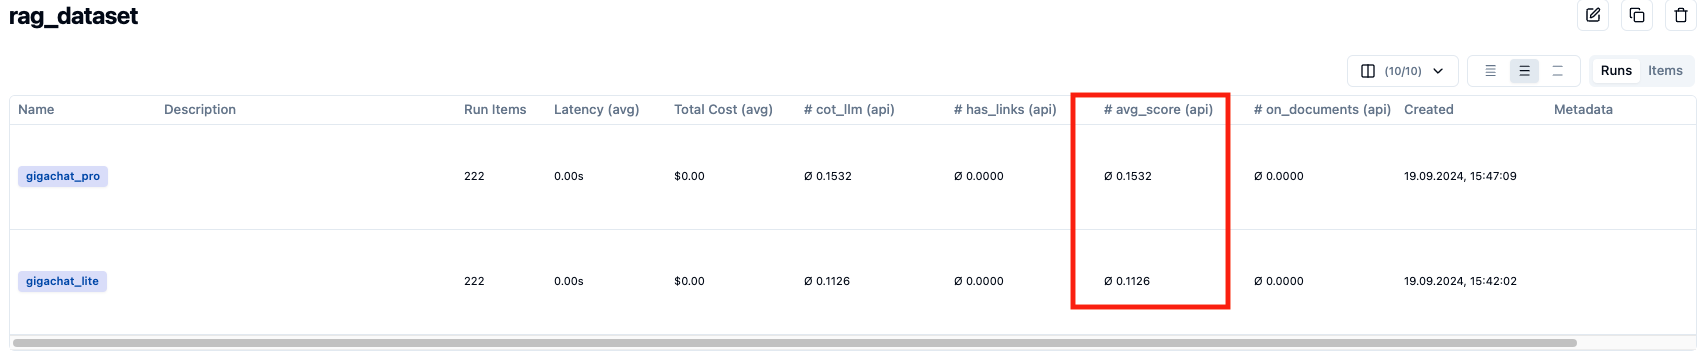

Судя по всему GigaChat хорошо справляется с вопросами сам о себе, но про GigaChain отвечает слабо.
Теперь попробуем прогнать датасет с простым RAG

### Оценка ответов GigaChat + RAG(стандартный)
Для начала инициализируем векторную базу данных. В этом примере используется внешняя БД Pinecone

In [38]:
from langchain_pinecone import PineconeVectorStore
from langchain_openai.embeddings import OpenAIEmbeddings
from pinecone import Pinecone

pinecone_api_key = os.environ.get("PINECONE_API_KEY")

pc = Pinecone(api_key=pinecone_api_key)
index_name = "gigachain-test-index-gpt-7"
index = pc.Index(index_name)

embeddings = OpenAIEmbeddings()
vector_store = PineconeVectorStore(index=index, embedding=embeddings)

Собираем цепочку с RAG

In [40]:
from langchain_core.runnables import RunnableParallel
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.chains.question_answering.stuff_prompt import CHAT_PROMPT

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain_from_docs = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | CHAT_PROMPT
    | llm
    | StrOutputParser()
)

rag_chain_with_source = RunnableParallel(
    {"context": vector_store.as_retriever(), "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

In [41]:
rag_chain_with_source.invoke("Как обновить GigaChain?")['answer']

'Выполните команду bash pip install -U gigachain_community'

In [42]:
await evaluate("simple_rag", rag_chain_with_source)


100%|██████████| 74/74 [08:36<00:00,  6.97s/it]


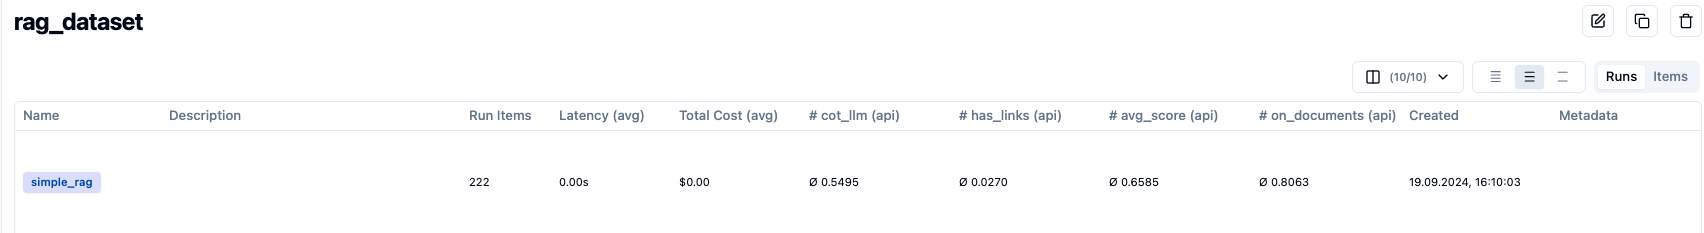

Оценка - 0.65

### Оценка ответов GigaChat + Adaptive RAG

In [47]:
from graph import graph, GraphState

In [52]:
generation = await graph.ainvoke(input=GraphState(question="Как обновить GigaChain?"))
print(generation['generation'])

Чтобы обновить GigaChain до последней версии, запустите команду `pip install -U gigachain_community` в терминале. Если у вас есть другие вопросы или нужна помощь, вы можете обратиться к документации по GigaChain на сайте разработчиков SberDevices.


In [59]:
await evaluate("arag_3", graph, graph=True)

100%|██████████| 74/74 [15:41<00:00, 12.72s/it]


Смотрим результат...
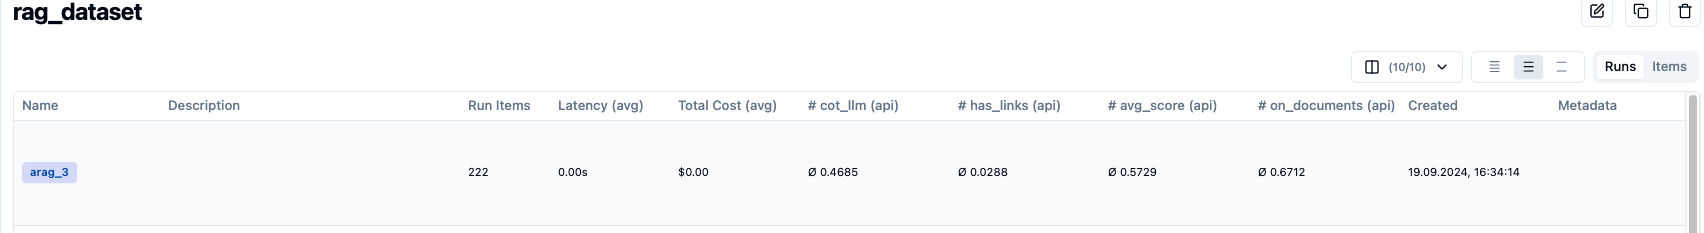
Результат вышел `0.57`, меньше чем у просто RAG.
Почему?
Дело в том, что ARAG сам выбирает относиться ли вопрос к нашей векторной базе данных,
и может отказаться от ответа, не обращаясь к ней. Здесь качество зависит от качества промпта
который направляет запрос в графе.
### Оценка ответов Support Bot

In [61]:
from graph_3 import graph as graph_3
(await graph_3.ainvoke(input=GraphState(question="Как обновить GigaChain?")))['generation']

'Для обновления GigaChain выполните команду `bash pip install -U gigachain_community`. Более подробную информацию и примеры можно найти в [документации](https://developers.sber.ru/docs/ru/gigachain/overview) и [репозитории](https://github.com/ai-forever/gigachain) на GitHub.'

In [62]:
await evaluate("support_bot_v3", graph_3, graph=True)

100%|██████████| 74/74 [15:43<00:00, 12.75s/it]


Смотрим результат...
![скриншот прогона](media/llm_with_support_bot.png)
Результат вышел `0.79`.

In [63]:
from graph_2 import graph as graph_2
await evaluate("support_bot_v2", graph_2, graph=True)

100%|██████████| 74/74 [16:14<00:00, 13.17s/it] 


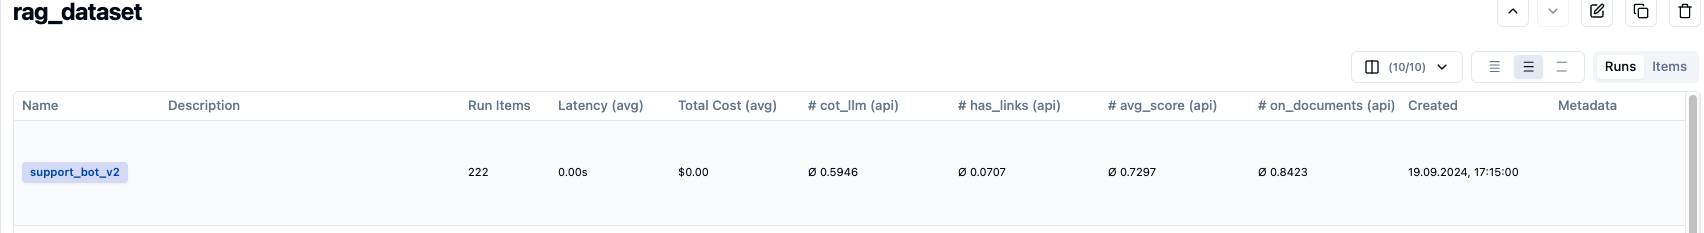

На данный момент эта версия дает наилучшее качество